# Data Visualisation

First install the required libraries if you haven't done so already (uncomment the lines below):

In [17]:
# !pip install folium
# !pip install mplcursors
# !pip install plotly

Import the necessary libraries:

In [18]:
from pymongo import MongoClient
import pandas as pd
import folium
from datetime import datetime, date, time as dt_time
from folium.features import DivIcon
import matplotlib.pyplot as plt
import time
import matplotlib.dates as mdates
from pyspark.sql.window import Window
from pyspark.sql.functions import (
    window,
    mean,
    col,
    expr,
    percentile_approx,
    count,
)
from pyspark.sql.functions import (
    min as spark_min,
    max as spark_max,
    sum as spark_sum,
)
from pyspark.sql import SparkSession, DataFrame
import numpy as np
from ipywidgets import interact, widgets
from IPython.display import display
from pymongo.collection import Collection
from typing import List, Dict, Tuple, Any, Union
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from IPython.display import clear_output

First connect to the database and load the data from the collections for plotting

In [19]:
host_ip = "192.168.64.1"  # Replace with your MongoDB host IP address
client = MongoClient(host_ip, 27017)
db = client.fit3182_a2

vehicle_collection = db.vehicle
camera_collection = db.camera
violation_collection = db.violation

Load the camera data to a dictionary for plotting:

In [20]:
allCameras = camera_collection.find()
camera_dict = {cam["_id"]: cam for cam in allCameras}

Perform real-time plotting of two graphs per camera: (1) number of violations over arrival time, and (2) speed over arrival time, based on live incoming camera events.

In [21]:
# to enable interactive plots in Jupyter Notebook
%matplotlib notebook       

<IPython.core.display.Javascript object>


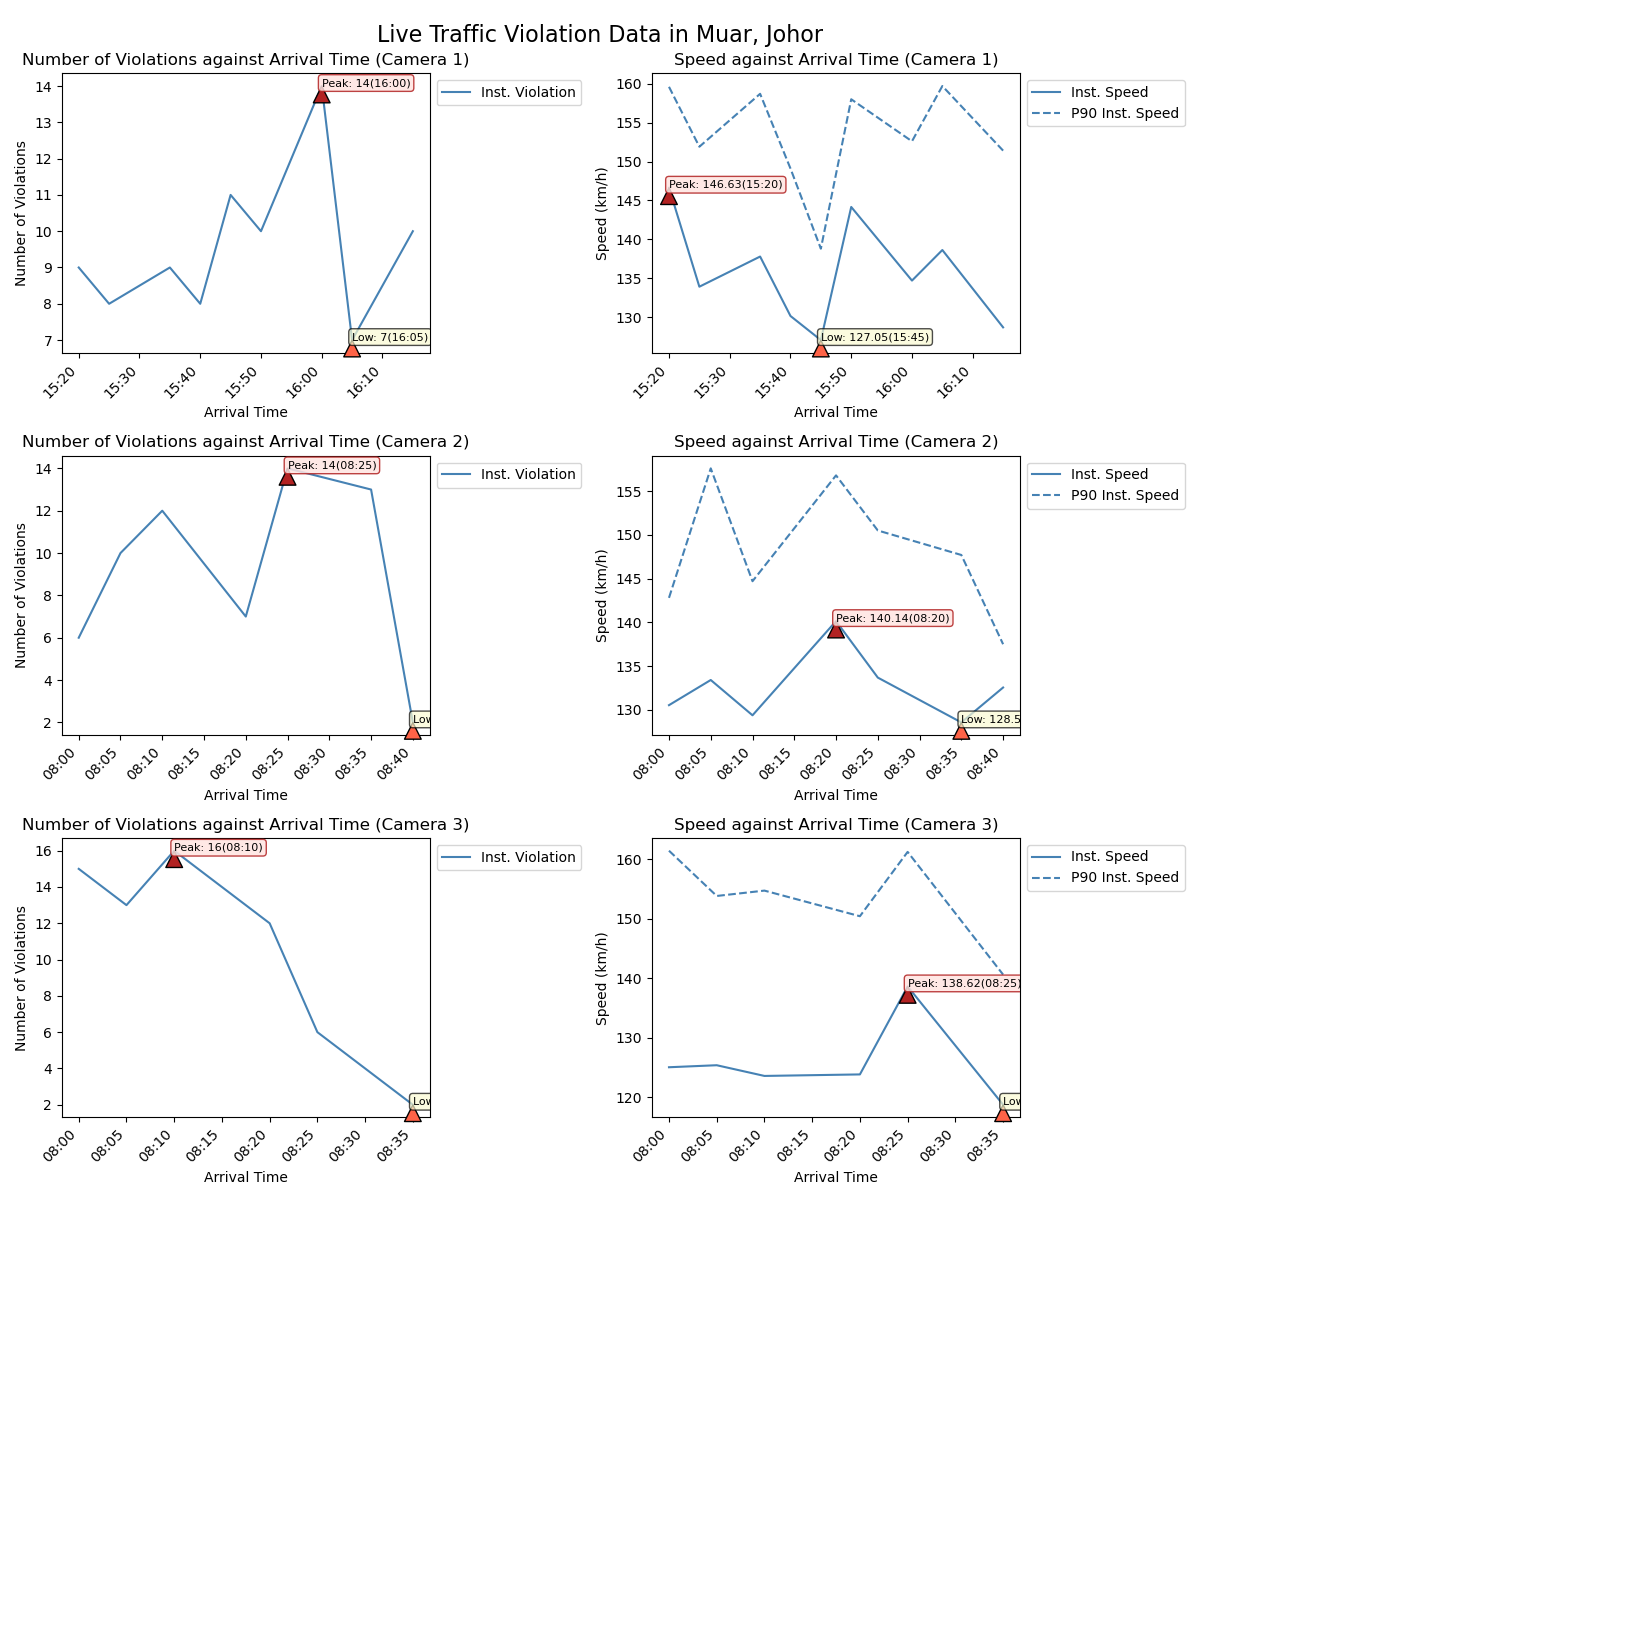

/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/conda/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/lib/python3.10/socket.py", line 717, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


Plotting interrupted by user.


In [22]:
def get_real_time_data(
    violation_collection: Collection, last_update_time: datetime
) -> Tuple[DataFrame, datetime]:
    """
    Fetches real-time data from the MongoDB collection and processes it 
    using PySpark.

    Args:
        violation_collection: MongoDB collection containing violation data.
        last_update_time: The last time the data was updated, used to filter 
        new records.

    Returns:
        A tuple containing a PySpark DataFrame with the processed data and the 
        updated last_update_time.
    """
    # Fetch updated data from MongoDB
    updated_collection = violation_collection.aggregate(
        [
            {
                "$match": {
                    "updateAt": {"$gt": last_update_time},
                    "violations.updatedAt": {"$gt": last_update_time},
                }
            },
            {
                "$unwind": {
                    "path": "$violations",
                    "preserveNullAndEmptyArrays": True,
                }
            },
            {
                "$project": {
                    "camera_id": "$violations.camera_id_end",
                    "arrival_time": {
                        "$dateTrunc": {
                            "date": "$violations.timestamp_end",
                            "unit": "minute",
                            "binSize": 5,  # Truncate to 5-minute intervals
                        }
                    },
                    "updatedAt": "$violations.updatedAt",
                    "speed_reading": "$violations.speed_reading",
                    "type": "$violations.type",
                }
            },
        ]
    )
    data = list(updated_collection)
    if len(data) > 0:
        # Remove MongoDB ObjectId field if present for compatibility with Spark
        for doc in data:
            doc.pop("_id", None)
        spark = SparkSession.builder.appName("MongoToSpark").getOrCreate()
        updated_df = spark.createDataFrame(data)

        # Filter out data that exceed the time frame for each camera
        windowSpec = Window.partitionBy("camera_id")
        updated_df = updated_df.withColumn(
            "max_time_per_camera", spark_max("arrival_time").over(windowSpec)
        )
        updated_df = updated_df.withColumn(
            "cutoff_time", expr("max_time_per_camera - INTERVAL 1 HOUR")
        )
        updated_df = updated_df.filter(
            col("arrival_time") >= col("cutoff_time")
        )
        updated_df = updated_df.drop("max_time_per_camera", "cutoff_time")

        # Get the last update time for the next iteration
        outdated_df = updated_df.filter(
            col("arrival_time") < col("cutoff_time")
        )
        result = outdated_df.select(spark_max("updatedAt")).collect()
        if result and result[0][0] is not None:
            last_update = result[0][0]
        else:
            last_update = last_update_time

        # Group by 5-minute intervals and calculate the required statistics
        grouped_df = updated_df.groupBy(
            window("arrival_time", "5 minutes"), "camera_id", "type"
        ).agg(
            count("*").alias("total_violations"),
            mean("speed_reading").alias("avg_speed"),
            percentile_approx("speed_reading", 0.9).alias("p90_speed"),
        )
        grouped_df = (
            grouped_df.withColumn("start_time", col("window.start"))
            .withColumn("end_time", col("window.end"))
            .drop("window")
        )
        return (grouped_df, last_update)


def init_plots() -> (Figure, List[Axes]):
    """
    Initializes the plots for real-time data visualization.

    Returns:
        A tuple containing the figure and a list of subplot axes.
    """
    try:
        # Initialize the figure and subplots
        width = 12
        height = 12
        fig = plt.figure(figsize=(width, height))
        fig.subplots_adjust(hspace=0.6)
        sub_plots = []
        cameras = len(camera_dict)
        count = 1
        # Create two subplots for each camera
        for key, cam in camera_dict.items():
            ax_1 = fig.add_subplot(cameras, 2, count)
            ax_1.set_title(
                f"Number of Violations against Arrival Time (Camera {cam['_id']})"
            )
            ax_1.set_xlabel("Arrival Time")
            ax_1.set_ylabel("Number of Violations")
            sub_plots.append(ax_1)
            count += 1
            ax_2 = fig.add_subplot(cameras, 2, count)
            ax_2.set_title(f"Speed against Arrival Time (Camera {cam['_id']})")
            ax_2.set_xlabel("Arrival Time")
            ax_2.set_ylabel("Speed (km/h)")
            count += 1
            sub_plots.append(ax_2)
        fig.suptitle("Live Traffic Violation Data in Muar, Johor", fontsize=16)
        fig.show()
        fig.canvas.draw()
        return fig, sub_plots
    except Exception as ex:
        print(str(ex))


def plot_cam_subplots(
    cam_id: int, cam_df: DataFrame, ax_1: Axes, ax_2: Axes
) -> None:
    """
    Plots the two subplots for a specific camera.
    (1) Number of violations against arrival time
    (2) Speed against arrival time
    Args:
        cam_id: The ID of the camera.
        cam_df: The DataFrame containing data for the specific camera.
        ax_1: The first subplot axis for number of violations.
        ax_2: The second subplot axis for speed.
    """
    # Plot number of violations against arrival time
    instant_violations = cam_df.filter(col("type") == "instant").orderBy(
        col("start_time").asc()
    )
    average_violations = cam_df.filter(col("type") == "average").orderBy(
        col("start_time").asc()
    )
    x_instant = []
    y1_instant = []
    x_average = []
    y1_average = []
    y2_instant_avg = []
    y2_instant_p90 = []
    y2_average_avg = []
    y2_average_p90 = []
    for row in instant_violations.collect():
        x_instant.append(row["start_time"])
        y1_instant.append(row["total_violations"])
        y2_instant_avg.append(row["avg_speed"])
        y2_instant_p90.append(row["p90_speed"])

    for row in average_violations.collect():
        x_average.append(row["start_time"])
        y1_average.append(row["total_violations"])
        y2_average_avg.append(row["avg_speed"])
        y2_average_p90.append(row["p90_speed"])

    ax_1.clear()
    if x_instant and y1_instant:
        ax_1.plot(
            x_instant, y1_instant, color="steelblue", label="Inst. Violation"
        )
        annotate_max(x_instant, y1_instant, ax_1)
        annotate_min(x_instant, y1_instant, ax_1)
        annotate_spike_drops(x_instant, y1_instant, ax_1)
        ax_1.legend(loc="upper left", bbox_to_anchor=(1, 1))
    if x_average and y1_average:
        ax_1.plot(
            x_average, y1_average, color="seagreen", label="Avg Violation"
        )
        annotate_max(x_average, y1_average, ax_1)
        annotate_min(x_average, y1_average, ax_1)
        annotate_spike_drops(x_average, y1_average, ax_1)
        ax_1.legend(loc="upper left", bbox_to_anchor=(1, 1))
    ax_1.set_title(
        f"Number of Violations against Arrival Time (Camera {cam_id})"
    )
    ax_1.set_xlabel("Arrival Time")
    ax_1.set_ylabel("Number of Violations")
    ax_1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    plt.setp(ax_1.get_xticklabels(), rotation=45, ha="right")

    # Plot speed against arrival time
    # Plot instant violations speed
    ax_2.clear()

    if x_instant and y2_instant_avg and y2_instant_p90:
        ax_2.plot(
            x_instant, y2_instant_avg, color="steelblue", label="Inst. Speed"
        )
        ax_2.plot(
            x_instant,
            y2_instant_p90,
            color="steelblue",
            ls="--",
            label="P90 Inst. Speed",
        )
        annotate_max(x_instant, y2_instant_avg, ax_2)
        annotate_min(x_instant, y2_instant_avg, ax_2)
        annotate_spike_drops(x_instant, y2_instant_avg, ax_2)
        ax_2.legend(loc="upper left", bbox_to_anchor=(1, 1))

    # Plot average violations speed
    if x_average and y2_average_avg and y2_average_p90:
        ax_2.plot(
            x_average, y2_average_avg, color="seagreen", label="Avg Speed"
        )
        ax_2.plot(
            x_average,
            y2_average_p90,
            color="seagreen",
            ls="--",
            label="P90 Avg Speed",
        )
        annotate_max(x_average, y2_average_avg, ax_2)
        annotate_min(x_average, y2_average_avg, ax_2)
        ax_2.legend(loc="upper left", bbox_to_anchor=(1, 1))

    ax_2.set_title(f"Speed against Arrival Time (Camera {cam_id})")
    ax_2.set_xlabel("Arrival Time")
    ax_2.set_ylabel("Speed (km/h)")
    ax_2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    plt.setp(ax_2.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout()


def annotate_max(x: List[datetime], y: List[float], ax=None) -> None:
    """
    Annotates the maximum value in the plot with an arrow and text.
    Args:
        x: List of x-coordinates (timestamps).
        y: List of y-coordinates (values).
        ax: The axis to annotate. If None, uses the current axis.
    """
    ymax = max(y)
    idx = y.index(ymax)
    xmax = x[idx]
    text = f"Peak: {round(ymax, 2)}({xmax.strftime('%H:%M')})"

    if ax is None:
        ax = plt.gca()

    ax.annotate(
        text,
        xy=(xmax, ymax),
        xytext=(xmax, ymax),
        textcoords="data",
        arrowprops=dict(facecolor="firebrick", shrink=0.05),
        bbox=dict(
            boxstyle="round,pad=0.3",
            fc="mistyrose",
            edgecolor="firebrick",
            alpha=0.85,
        ),
        fontsize=8,
        clip_on=True,
    )


def annotate_min(x: List[datetime], y: List[float], ax=None) -> None:
    """
    Annotates the minimum value in the plot with an arrow and text.

    Args:
        x: List of x-coordinates (timestamps).
        y: List of y-coordinates (values).
        ax: The axis to annotate. If None, uses the current axis.
    """
    ymin = min(y)
    idx = y.index(ymin)
    xmin = x[idx]
    text = f"Low: {round(ymin, 2)}({xmin.strftime('%H:%M')})"

    if ax is None:
        ax = plt.gca()

    ax.annotate(
        text,
        xy=(xmin, ymin),
        xytext=(xmin, ymin),
        textcoords="data",
        arrowprops=dict(facecolor="tomato", shrink=0.05),
        bbox=dict(
            boxstyle="round,pad=0.3", fc="lightgoldenrodyellow", alpha=0.7
        ),
        fontsize=8,
        clip_on=True,
    )


def annotate_spike_drops(
    x: List[datetime], y: List[float], ax=None, window=1
) -> None:
    """
    Annotates spikes and drops in the data with shaded regions.

    Args:
        x: List of x-coordinates (timestamps).
        y: List of y-coordinates (values).
        ax: The axis to annotate. If None, uses the current axis.
        window: Number of points to extend the shaded region around the 
        spike/drop.
    """
    if len(y) > 1:
        y_diff = np.diff(y)
        threshold = np.std(y_diff, ddof=1) * 2
        spikes = np.where(y_diff > threshold)[0] + 1
        # Annotate spikes with shaded regions
        for i in spikes:
            ax.axvspan(
                x[max(0, i - window)],
                x[min(len(x) - 1, i + window)],
                color="red",
                alpha=0.2,
                label="Alert" if i == spikes[0] else "",
            )
        drops = np.where(y_diff < -threshold)[0] + 1
        # Annotate drops with shaded regions
        for i in drops:
            ax.axvspan(
                x[max(0, i - window)],
                x[min(len(x) - 1, i + window)],
                color="blue",
                alpha=0.2,
                label="Calm" if i == drops[0] else "",
            )


def draw_plots(
    collection: Collection,
    camera_dict: Dict[int, Dict[str, Any]],
    fig: Figure,
    sub_plots: List[Axes],
) -> None:
    """
    Draws real-time plots for traffic violations from the MongoDB collection.

    Args:
        collection: MongoDB collection containing violation data.
        camera_dict: Dictionary mapping camera IDs to camera metadata.
        fig: The figure object for the plots.
        sub_plots: List of subplot axes for each camera.
    """
    try:
        # Initialize the last update time (as the current time)
        last_update_time = datetime.utcnow()
        while True:
            # Fetch real-time data from MongoDB and process it with PySpark
            result = get_real_time_data(collection, last_update_time)
            if result:
                df, last_update_time = result
                # Draw plot for each camera
                count = 0
                for cam_id in camera_dict:
                    plot_cam_subplots(
                        cam_id,
                        df.filter(col("camera_id") == cam_id),
                        sub_plots[count],
                        sub_plots[count + 1],
                    )
                    count += 2
                # Update the figure
                fig.canvas.draw()
                fig.canvas.flush_events()
            time.sleep(5)

    except KeyboardInterrupt:
        print("Plotting interrupted by user.")
        plt.close("all")

    except Exception as ex:
        print(str(ex))
        plt.close("all")


if __name__ == "__main__":
    fig, sub_plots = init_plots()
    draw_plots(violation_collection, camera_dict, fig, sub_plots)


For each camera, I created two separate graphs to handle the different processing times encountered in PySpark. Using a shared x-axis across all cameras would complicate comparisons due to asynchronous event timings. Instead, I arranged the cameras in rows, with two subplots per camera, one showing the number of violations and the other showing exceeded speeds. This layout enables clearer, side-by-side comparison within each camera and top-to-bottom comparison across camera pairs.

By ordering the cameras vertically and grouping each camera pair in consecutive rows (top and bottom), the design further enhances the ability to compare speeds and violations between adjacent segments. This modular structure also supports future scalability: as more cameras are added, new subplot pairs can be appended at the bottom using the same plotting functions, preserving clarity and simplifying comparisons as the system expands.

#### (1) Number of Violations vs. Arrival Time Graph
This line graph presents a time series of traffic violation counts within a one-hour sliding window. This graph supports real-time monitoring and informed enforcement planning. By clearly showing when and what types of violations occur, it enables data-driven decisions for resource deployment, camera placement, and traffic policy improvements, ultimately enhancing road safety.

Key Features and Insights:
- **X-axis (Arrival Time)**: Represents when vehicles passed the camera, revealing how violation patterns evolve over time. This supports detection of peak risk periods such as rush hours or late-night speeding.
- **Y-axis (Violation Count)**:Displays the number of detected violations, making it easy to observe how many violations happen over time and whether they are increasing, stable, or declining.
- **Color-Coded Lines (Violation Types)**: Differentiate between two violation types to help reveal whether drivers tend to speed briefly near a camera or consistently over a longer segment, informing what type of enforcement is more effective.
    - **Blue**: Represents instantaneous speeding violations. 
    - **Green**: Represents average segment speed violations.
- **Interesting points**: These markers help prioritize enforcement timing and evaluate the effectiveness of safety measures.
    - **Peak**:The highest violation peaks highlight periods of increased risk where enforcement or preventive measures may be needed.
    - **Low**: The lowest points suggest safer driving periods or effective deterrence.
- **Shaded regions**: The graph includes shaded regions to indicate periods of reduced or increased violations, helping to identify trends and anomalies in traffic behavior.
    - **Calm**: These may indicate lower traffic volume, effective deterrents, or data issues. Recognizing this helps validate system performance or assess intervention impact.
    - **Alert**: These highlight periods that may require immediate attention such as more patrols or safety alerts.

#### (2) Speed vs. Arrival Time Graph
This line graph complements the violation count graph by displaying instantaneous speeds (measured at each camera) and average segment speeds (between camera pairs) for vehicles involved in violations, aligned with their arrival time.

Key Features and Insights:
- **X-axis (Arrival Time)**: Matches the violation count graph, allowing direct correlation between speed and violation patterns over time.
- **Y-axis (Speed)**: Displays vehicle speeds(km/h), enabling quick identification of speeding trends and behaviors.
- **Color-Coded Lines**: Differentiate between instantaneous and average speeds to provide a comprehensive view of driving behavior.
    - **Blue**: Represents instantaneous speeds at the start camera.
    - **Green**: Represents average segment speeds between the start and end cameras.
    - **Blue Dotted Line**: Represents the 90th percentile of instantaneous speeds, highlighting the fastest 10% of vehicles to help identify those most likely to exceed speed limits and pose greater risk.
    - **Green Dotted Line**: Represents the 90th percentile of average segment speeds, providing a benchmark for typical driving behavior over longer segments.
- **Interesting Points**: Key moments of high and low speeds are clearly labeled to spotlight critical driving behaviors.
    - **Peak**: Indicates peak speeds, pointing to critical periods of extreme speeding that may require immediate enforcement.
    - **Low**: Indicates periods of reduced speeds, which may suggest safer driving or abrupt deceleration behavior.
- **Shaded regions**: These regions help visualize periods of consistent speeding or sudden changes in driving behavior.
    - **Calm**: Denotes intervals of stable or slower instantaneous speeds, potentially reflecting lower risk or lighter flow.
    - **Alert**: Highlights periods with rapid increases in instantaneous speed, signaling heightened risk that may need intervention or enhanced monitoring.

**Extra Insights Gained**
By analyzing speed trends alongside violation counts, the graph reveals important patterns in driver behavior, enforcement gaps, and risk periods:
- **Driver Behavior Patterns**: Low instantaneous speeds near cameras but high average segment speeds suggest drivers slow only when observed, exposing enforcement blind spots. Consistently high speeds in both metrics point to widespread speeding requiring broader intervention.
- **Enforcement Gaps**: If average segment speeds are consistently higher than instantaneous speeds, it suggests that drivers are slowing down only near cameras, indicating a need for more balanced camera placement.
- **Trend & Risk Monitoring**: Speed and violation spikes highlight critical periods for enforcement. If the 90th percentile of instantaneous speeds exceeds the speed limit, it flags timeframes with frequent high-speed violations.
- **Camera Effectiveness Evaluation**: Large differences between start and end camera speeds may expose drivers adjusting behavior to "game" the system where slowing down only when in view, reducing the effectiveness of fixed cameras and calling for smarter enforcement strategies.

Overall, these two graphs enable real-time traffic monitoring and strategic resource allocation by highlighting when and where violations peak and the predominant violation types. This supports smarter enforcement planning, optimized camera placement, and more effective policy decisions, empowering authorities to respond proactively and improve road safety outcomes.

Create a map visualizing camera locations and their corresponding violation counts, highlighting cameras with more than 100 violations (threshold) within any one-hour period of the day as hotspots.

In [23]:
def to_datetime(dt: Union[date, datetime]) -> datetime:
    """
    Converts a date or datetime object to a datetime object.
    If the input is a date object, it combines it with the minimum time 
    (00:00:00).
    
    Args:
        dt: A date or datetime object.
        
    Returns:
    A datetime object.
    """
    if isinstance(dt, date) and not isinstance(dt, datetime):
        return datetime.combine(dt, dt_time.min)
    return dt


def filter_selected_date(
    violation_collection: Collection, start_date: datetime, end_date: datetime
) -> Union[Tuple[DataFrame, DataFrame], DataFrame, Any]:
    """
    Filters the violation collection for violations within a specified date 
    range.
    
    Args:
        violation_collection: MongoDB collection containing violation data.
        start_date: The start date for filtering violations.
        end_date: The end date for filtering violations.
        
    Returns:
        A tuple containing two DataFrames:
        - all_violations: DataFrame with all violations 
        (both 'instant' and 'average') 
        for the specified date range.
        - avg_violations: DataFrame with average violations for the specified 
        date range.
    """
    start_date = to_datetime(start_date)
    end_date = to_datetime(end_date)
    # Aggregate violations('instant' & 'average') for the specified date range
    all_violation_collection = violation_collection.aggregate(
        [
            {"$match": {"date": {"$gte": start_date, "$lt": end_date}}},
            {"$unwind": "$violations"},
            {
                "$project": {
                    "type": "$violations.type",
                    "camera_id": "$violations.camera_id_end",
                    "hour": {
                        "$hour": {"$toDate": "$violations.timestamp_end"}
                    },
                    "speed_reading": "$violations.speed_reading",
                }
            },
            {
                "$group": {
                    "_id": {"hour": "$hour", "camera_id": "$camera_id"},
                    "violation_count": {"$sum": 1},
                    "exceeded_speed": {"$avg": "$speed_reading"},
                }
            },
            {"$sort": {"_id.hour": 1}},
        ]
    )
    # Aggregate average violations for the specified date range
    avg_violation_collection = violation_collection.aggregate(
        [
            {"$match": {"date": {"$gte": start_date, "$lt": end_date}}},
            {"$unwind": "$violations"},
            {"$match": {"violations.type": "average"}},
            {
                "$project": {
                    "type": "$violations.type",
                    "camera_id_start": "$violations.camera_id_start",
                    "camera_id_end": "$violations.camera_id_end",
                    "hour": {
                        "$hour": {"$toDate": "$violations.timestamp_end"}
                    },
                    "speed_reading": "$violations.speed_reading",
                }
            },
            {
                "$group": {
                    "_id": {
                        "hour": "$hour",
                        "camera_id_start": "$camera_id_start",
                        "camera_id_end": "$camera_id_end",
                        "type": "$type",
                    },
                    "violation_count": {"$sum": 1},
                    "exceeded_speed": {"$avg": "$speed_reading"},
                }
            },
            {"$sort": {"_id.hour": 1}},
        ]
    )

    # Convert the aggregation results to Pandas DataFrames
    all_violations_data = list(all_violation_collection)
    avg_violations_data = list(avg_violation_collection)
    all_violations_df = pd.DataFrame(all_violations_data)
    avg_violations_df = pd.DataFrame(avg_violations_data)

    # Expand the '_id' dictionary into separate columns
    all_violations = None
    if all_violations_df is not None and len(all_violations_df) > 0:
        all_id_cols = all_violations_df["_id"].apply(pd.Series)
        all_violations = pd.concat(
            [all_id_cols, all_violations_df.drop(columns=["_id"])], axis=1
        )
    avg_violations = None
    if avg_violations_df is not None and len(avg_violations_df) > 0:
        avg_id_cols = avg_violations_df["_id"].apply(pd.Series)
        avg_violations = pd.concat(
            [avg_id_cols, avg_violations_df.drop(columns=["_id"])], axis=1
        )
    return all_violations, avg_violations

In [24]:
def map_center(
    camera_dict: Dict[int, Dict[str, Any]],
) -> tuple[float, float, float, float, float, float]:
    """
    Computes the center of the map based on the latitude and longitude of 
    all cameras.
    
    Args:
        camera_dict: Dictionary mapping camera IDs to camera metadata.
        
    Returns:
    A tuple containing the minimum latitude, maximum latitude, minimum 
    longitude, maximum longitude, center latitude, and center longitude.
    
    """
    # Extract all latitudes and longitudes
    lats = [coord["latitude"] for coord in camera_dict.values()]
    lons = [coord["longitude"] for coord in camera_dict.values()]
    min_lat = min(lats)
    max_lat = max(lats)
    min_lon = min(lons)
    max_lon = max(lons)

    # Compute center of the map
    center_lat = (min_lat + max_lat) / 2
    center_lon = (min_lon + max_lon) / 2
    return min_lat, max_lat, min_lon, max_lon, center_lat, center_lon

In [25]:
def update_map(
    violation_collection: Collection,
    camera_dict: Dict[int, Dict[str, Any]],
    hour: int,
    start_date: datetime,
    end_date: datetime,
) -> None:
    """
    Dynamically update the map with camera locations and hotspots based on the
    hour chosen using the slider.

    Args:
        hour: The hour of the day to filter violations (slider input).
        start_date: The start date for filtering violations.
        end_date: The end date for filtering violations.
    """
    clear_output(wait=True)
    all_violations, avg_violations = filter_selected_date(
        violation_collection, start_date, end_date
    )
    # Create a Folium map centered around the camera locations
    min_lat, max_lat, min_lon, max_lon, center_lat, center_lon = map_center(
        camera_dict
    )
    m = folium.Map(location=[center_lat, center_lon], zoom_start=15)
    m.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])

    # Add camera markers on the map
    for key, cam in camera_dict.items():
        cam_id, lat, lon, limit = (
            cam["_id"],
            cam["latitude"],
            cam["longitude"],
            cam["speed_limit"],
        )
        folium.Marker(
            location=[lat, lon],
            popup=f"<b>Camera</b> {cam_id}\n<b>Latitude:</b>{lat}\n<b>Longitude:</b>{lon}\n<b>Speed Limit:</b>{limit}km/h",
            icon=folium.Icon(color="gray", icon="camera"),
        ).add_to(m)

    if all_violations is not None and len(all_violations):
        # Plot hotspot camera locations (number of violations > threshold)
        threshold = 100
        hotspots = all_violations[
            (all_violations["hour"] == hour)
            & (all_violations["violation_count"] > threshold)
        ]
        for _, row in hotspots.iterrows():
            cam = row["camera_id"]
            cam_lat, cam_lon = (
                camera_dict[cam]["latitude"],
                camera_dict[cam]["longitude"],
            )
            violations = int(row["violation_count"])
            exceeded_speed = round(row["exceeded_speed"], 2)
            popup_html = f"<b>Hour:</b> {hour}:00\n<b>Violations:</b> {violations}\n<b>Exceeded Speed:</b> {exceeded_speed}km/h"
            popup = folium.Popup(popup_html, max_width=100)
            folium.Marker(
                location=[cam_lat, cam_lon],
                icon=DivIcon(
                    icon_size=(150, 36),
                    icon_anchor=(0, 0),
                    html=f"""<div style="font-size: 11pt; color: red; background-color: rgba(255,255,255,0.7);
                    padding: 4px 8px; border-radius: 8px; text-align: center; width: max-content;"">
                    {violations}
                    </div>""",
                ),
                popup=popup,
            ).add_to(m)
            folium.CircleMarker(
                location=(cam_lat, cam_lon),
                radius=20,
                color="red",
                fill=True,
                fill_opacity=0.7,
            ).add_to(m)
        # Plot camera locations (number of violations < threshold)
        not_hotspots = all_violations[
            (all_violations["hour"] == hour)
            & (all_violations["violation_count"] < threshold)
        ]
        for _, row in not_hotspots.iterrows():
            cam = row["camera_id"]
            cam_lat, cam_lon = (
                camera_dict[cam]["latitude"],
                camera_dict[cam]["longitude"],
            )
            violations = int(row["violation_count"])
            exceeded_speed = round(row["exceeded_speed"], 2)
            popup_html = f"<b>Hour:</b> {hour}:00\n<b>Violations:</b> {violations}\n<b>Exceeded Speed:</b> {exceeded_speed}km/h"
            popup = folium.Popup(popup_html, max_width=100)
            folium.Marker(
                location=[cam_lat, cam_lon],
                icon=DivIcon(
                    icon_size=(150, 36),
                    icon_anchor=(0, 0),
                    html=f"""<div style="font-size: 11pt; color: black; background-color: rgba(255,255,255,0.7);
                    padding: 4px 8px; border-radius: 8px; text-align: center; width: max-content;"">
                    {violations}
                    </div>""",
                ),
                popup=popup,
            ).add_to(m)

    if avg_violations is not None and len(avg_violations):
        # Plot the number of violations (average)
        filtered_avg = avg_violations[avg_violations["hour"] == hour]
        for _, row in filtered_avg.iterrows():
            cam_start, cam_end = row["camera_id_start"], row["camera_id_end"]
            cam_start_lat, cam_start_lon = (
                camera_dict[cam_start]["latitude"],
                camera_dict[cam_start]["longitude"],
            )
            cam_end_lat, cam_end_lon = (
                camera_dict[cam_end]["latitude"],
                camera_dict[cam_end]["longitude"],
            )
            mid_lat, mid_lon = (cam_start_lat + cam_end_lat) / 2, (
                cam_start_lon + cam_end_lon
            ) / 2
            violations = row["violation_count"]
            exceeded_speed = round(row["exceeded_speed"], 2)
            popup_html = f"<b>Hour:</b> {hour}:00\n<b>Violations:</b> {violations}\n<b>Exceeded Speed:</b> {exceeded_speed}km/h"
            popup = folium.Popup(popup_html, max_width=100)
            folium.Marker(
                location=[mid_lat + 0.0015, mid_lon - 0.0005],
                icon=DivIcon(
                    icon_size=(150, 36),
                    icon_anchor=(0, 0),
                    html=f"""<div style="font-size: 11pt; color: black; background-color: rgba(255,255,255,0.7);
                    padding: 4px 8px; border-radius: 8px; text-align: center; width: max-content;"">
                    {violations} violations between {cam_start} and {cam_end} 
                    </div>""",
                ),
                popup=popup,
            ).add_to(m)
    start_str = start_date.strftime("%d/%m/%Y")
    end_str = end_date.strftime("%d/%m/%Y")
    # Add a title to the map
    title_html = f"""
     <h3 align="center" style="font-size:20px"><b>Number of Traffic Violations Recorded from {start_str} to {end_str} in Muar, Johor</b></h3>
     """
    m.get_root().html.add_child(folium.Element(title_html))
    display(m)


def update_map_wrapper(
    hour: int,
    start_picker: Union[date, datetime],
    end_picker: Union[date, datetime],
) -> None:
    """
    Wrapper function to update the map based on user-selected hour and date range.
    Helps to interact with the map dynamically using ipywidgets.
    
    Args:
        hour: The hour of the day to filter violations (slider input).
        start_picker: The start date for filtering violations.
        end_picker: The end date for filtering violations.
    """
    update_map(
        violation_collection, camera_dict, hour, start_picker, end_picker
    )


# Create 24 hours slider for user interaction
hours = [(f"{h:02d}:00", h) for h in range(24)]

# Create date
start_date_picker = widgets.DatePicker(
    description="Start Date", value=datetime(2024, 1, 1)
)
end_date_picker = widgets.DatePicker(
    description="End Date", value=datetime(2024, 1, 2)
)

interact(
    update_map_wrapper,
    hour=widgets.SelectionSlider(
        options=hours,
        description="Time:",
        continuous_update=False,  # only update after sliding finishes
        orientation="horizontal",  # horizontal slider
        style={"description_width": "initial"},  # full label width
        layout=widgets.Layout(width="50%"),  # wider slider
    ),
    start_picker=start_date_picker,
    end_picker=end_date_picker,
)

interactive(children=(SelectionSlider(continuous_update=False, description='Time:', layout=Layout(width='50%')…

<function __main__.update_map_wrapper(hour: int, start_picker: Union[datetime.date, datetime.datetime], end_picker: Union[datetime.date, datetime.datetime]) -> None>

This map displays the locations of traffic cameras and road segments along with their respective speed limits, enabling the identification of high-risk areas with frequent speeding violations. The number of violations between camera checkpoints is visualized to highlight the most dangerous road segments, while the average exceeded speed provides insight into the severity of speeding in each region.

The graph highlights distinct traffic hotspots where violations surpass a threshold of 100 per kilometer per day, a level widely recognized as critical. While the typical range for identifying speeding hotspots falls between 50 and 100 violations/km/day, the 100-violation mark represents the upper limit of this range and is a strong indicator for triggering enforcement actions and safety interventions. These insights support data-driven enforcement, optimized resource deployment, and more effective traffic control strategies.

For future improvements, adding more cameras would enhance coverage and spatial accuracy. Including additional labeled camera points in the graph would further strengthen the system’s ability to detect and localize speeding behavior.

Overall, these visualizations serve as a powerful tool for improving road safety, informing policy decisions, raising public awareness, and prioritizing interventions in high-risk areas.